<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Chapter%2015%20-%20Processing%20Sequences%20Using%20RNNs%20and%20CNNs/06_multistep_forecast_using_deep_rnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MULTI STEP FORECAST USING DEEP RNN MODEL WITH DENSE LAYER**

In [1]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN

In [2]:
## define a function to generate time series
def generate_time_series(batch_size, n_steps):
  """ Function Returns a Numpy array of shape [batch_size, time steps, 1]
      Series is a sum of two sine waves of fixed amplitudes.
      But random frequencies and phases, plus some noise.
      :param :- batch_size : number of data points.
      :param :- n_steps :- number of steps.
  """
  freq1, freq2, offset1, offset2 = np.random.randn(4, batch_size, 1)
  time = np.linspace(0,1,n_steps)
  series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10))
  series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))
  series += 0.1 * np.sin(np.random.rand(batch_size, n_steps) - 0.5)
  return series[..., np.newaxis].astype(np.float32)

In [3]:
## define the sequence data, time series data.
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(X_train.shape)  ## [batch_size, time steps, dimensionality]
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7000, 50, 1)
(7000, 1)
(2000, 50, 1)
(2000, 1)
(1000, 50, 1)
(1000, 1)


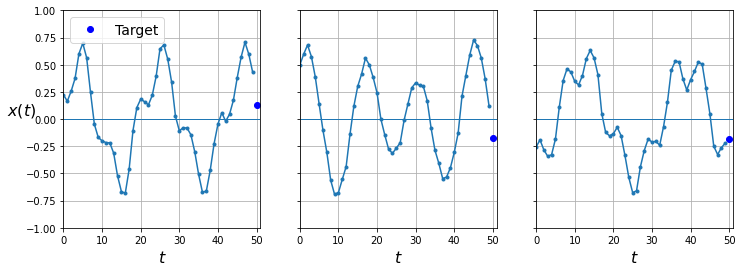

In [4]:
## plot the series
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

## plotting validation set graph.

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [5]:
## Deep RNN with three layers.
## including two hidden layer.
## one output layer.
## return sequneces = True or the layers of hidden layers.
## bcz in keras, rnn layers will only return the final output.
## to make them return one output per time step.
## set return_sequences = True.
## by using the Dense layer, seems that model converges faster than simple RNN layer.
## and also if we want to change the default "tanh" activation function.
## we can use the Dense Layer.
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [6]:
## compile the model
model.compile(
    loss = "mse",
    optimizer = "adam"
)

In [7]:
## train the model
r = model.fit(X_train, y_train,
              validation_data = (X_valid, y_valid),
              epochs = 20)

Epoch 1/20
219/219 [==============================] - 8s 28ms/step - loss: 0.0594 - val_loss: 0.0153
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0107 - val_loss: 0.0087
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 4/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 8/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 9/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0067 - val_lo

In [13]:
n_steps = 50
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
# print(Y_pred)

1/1 [==============================] - 0s 31ms/step


In [9]:
Y_pred.shape  ## 10 means 10 step prediction, or forecasting.

(1, 10, 1)

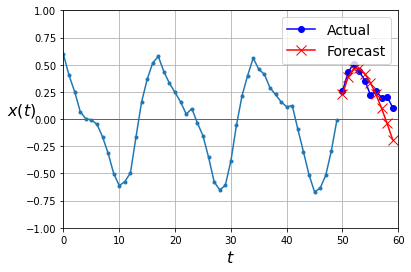

In [14]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show();

+ Now let's use this model to predict the next 10 values. 
+ We first need to regenerate the sequences with 9 more time steps.


In [21]:
## regenerating the sequence for another 9 more time steps
n_steps = 50   ## n steps = 50
series = generate_time_series(10000, n_steps + 10)  ## regenerating the time steps for another 9 steps.
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]   ## define the training set, test and validation set
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7000, 50, 1)
(7000, 1)
(2000, 50, 1)
(2000, 1)
(1000, 50, 1)
(1000, 1)


Now let's predict the next 10 values one by one:

In [27]:
X = X_valid
print("Before Predictions :--",X.shape)  ## here the shape is 50
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
print("After Predictions :--",X.shape)  ## here the shape is 60
Y_pred = X[:, n_steps:, 0]
print("Shape of the Predicted Output :--",Y_pred.shape)

Before Predictions :-- (2000, 50, 1)
63/63 [==============================] - 1s 8ms/step
After Predictions :-- (2000, 60, 1)
Shape of the Predicted Output :-- (2000, 10)


In [28]:
## mse between y_valid and y_pred
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.0742575

Let's compare this performance with some baselines: 
+ naive predictions and a simple linear model:

In [29]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
print(Y_naive_pred.shape)
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

(2000, 10)


0.17442837

MODEL

In [30]:
## define the model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
r = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1846 - val_loss: 0.1311
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1189 - val_loss: 0.1175
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1103 - val_loss: 0.1119
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1065 - val_loss: 0.1087
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1041 - val_loss: 0.1069
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1025 - val_loss: 0.1053
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1013 - val_loss: 0.1042
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1002 - val_loss: 0.1030
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0992 - val_loss: 0.1025
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0984 - val_loss: 0.1017

MODEL DEEP RNN MODEL

In [31]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)  ## 10 steps
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 30ms/step - loss: 0.1136 - val_loss: 0.0951
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0787 - val_loss: 0.0728
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0589 - val_loss: 0.0565
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0521 - val_loss: 0.0502
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0478 - val_loss: 0.0496
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0451 - val_loss: 0.0442
Epoch 7/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0438 - val_loss: 0.0455
Epoch 8/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0426 - val_loss: 0.0489
Epoch 9/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0414 - val_loss: 0.0404
Epoch 10/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0412 - val_l

In [33]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]
print(X_new.shape)
print(Y_new.shape)
print(Y_pred.shape)

1/1 [==============================] - 0s 41ms/step
(1, 50, 1)
(1, 10, 1)
(1, 10, 1)


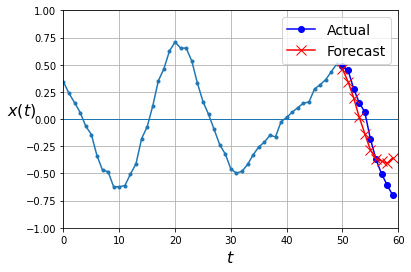

In [34]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show();

+ Now let's create an RNN that predicts the next 10 steps at each time step. 
+ That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, 
+ it will forecast time steps 1 to 10 at time step 0, 
+ then time steps 2 to 11 at time step 1, and so on, 
+ and finally it will forecast time steps 50 to 59 at the last time step. 
+ Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [40]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
print("Shape of Series :--", series.shape)
X_train = series[:7000, :n_steps]
print("Shape of Training Set :--", X_train.shape)
X_valid = series[7000:9000, :n_steps]
print("Shape of Validation Set :--", X_valid.shape)
X_test = series[9000:, :n_steps]
print("Shape of Testing Set :--", X_test.shape)
Y = np.empty((10000, n_steps, 10))
print("Shape of Y :--", Y.shape)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
print("Step of Training Labels :--", Y_train.shape)
Y_valid = Y[7000:9000]
print("Step of Validation Labels :--", Y_valid.shape)
Y_test = Y[9000:]
print("Step of Testing Labels :--", Y_test.shape)

Shape of Series :-- (10000, 60, 1)
Shape of Training Set :-- (7000, 50, 1)
Shape of Validation Set :-- (2000, 50, 1)
Shape of Testing Set :-- (1000, 50, 1)
Shape of Y :-- (10000, 50, 10)
Step of Training Labels :-- (7000, 50, 10)
Step of Validation Labels :-- (2000, 50, 10)
Step of Testing Labels :-- (1000, 50, 10)


In [41]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 29ms/step - loss: 0.0929 - last_time_step_mse: 0.0910 - val_loss: 0.0778 - val_last_time_step_mse: 0.0687
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0712 - last_time_step_mse: 0.0648 - val_loss: 0.0688 - val_last_time_step_mse: 0.0606
Epoch 3/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0702 - last_time_step_mse: 0.0635 - val_loss: 0.0693 - val_last_time_step_mse: 0.0593
Epoch 4/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0644 - last_time_step_mse: 0.0555 - val_loss: 0.0625 - val_last_time_step_mse: 0.0528
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0620 - last_time_step_mse: 0.0527 - val_loss: 0.0585 - val_last_time_step_mse: 0.0476
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0717 - last_time_step_mse: 0.0651 - val_loss: 0.0695 - val_last_time_step_mse: 0.0594
Epoch 7/20
219/219 [==

In [42]:
series = generate_time_series(1, 50 + 10)
print("Shape of the Series :--", series.shape)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
print(X_new.shape), print(Y_new.shape)
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
print(Y_pred.shape)

Shape of the Series :-- (1, 60, 1)
(1, 50, 1)
(1, 10, 1)
1/1 [==============================] - 1s 792ms/step
(1, 10, 1)


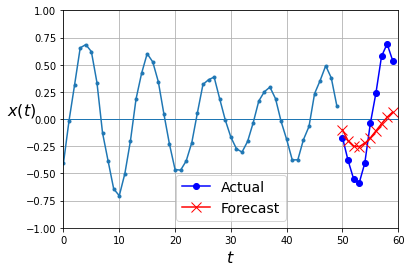

In [43]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show();

Here is the Prediction.

Deep RNN with Batch Normalization

In [44]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 35ms/step - loss: 0.2339 - last_time_step_mse: 0.2188 - val_loss: 0.1256 - val_last_time_step_mse: 0.1198
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0893 - last_time_step_mse: 0.0852 - val_loss: 0.0863 - val_last_time_step_mse: 0.0791
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0809 - last_time_step_mse: 0.0762 - val_loss: 0.0778 - val_last_time_step_mse: 0.0702
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0764 - last_time_step_mse: 0.0705 - val_loss: 0.0737 - val_last_time_step_mse: 0.0651
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0722 - last_time_step_mse: 0.0648 - val_loss: 0.0709 - val_last_time_step_mse: 0.0597
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0687 - last_time_step_mse: 0.0594 - val_loss: 0.0672 - val_last_time_step_mse: 0.0550
Epoch 7/20
219/219 [=

Shape of the Series :-- (1, 60, 1)
(1, 50, 1)
(1, 10, 1)
1/1 [==============================] - 1s 590ms/step
(1, 10, 1)


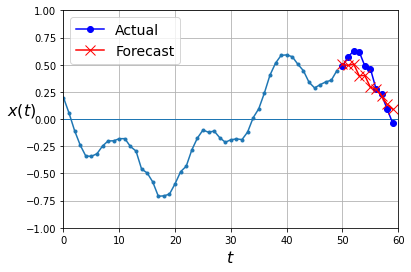

In [45]:
series = generate_time_series(1, 50 + 10)
print("Shape of the Series :--", series.shape)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
print(X_new.shape), print(Y_new.shape)
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
print(Y_pred.shape)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show();

These are the Outputs of the Predictions.

***